<h2 align="center"> Finding the Most Suitable Neighborhood to Visit in Bali, Indonesia </h2>
<h3 align="center"> Capstone Project - The Battle of Neighborhood </h3>
<h3 align="center"> IBM Data Science Professional Certification </h3>

<h4> Author: Rafki Islamy </h4>

### Introduction: Business Problem

According to Bali Local Tourism Officer, about 16.83 million of tourists come to Bali in 2019. Along with that number, 6.28 million of them are foreign tourists who come from various countries in the world. The number of visitor has grown significantly and has the potential to grow bigger in the future, with exception of pandemic period that would make a correction.

The number of tourist to Bali, which is expected to increase, will also result in an increase in the variation of tourist preferences for the place or area they want to visit. This may happen because each group of tourist has different demographics that affect the choice a particular place or area. For example, the tourist from non-tropical countries have a tendency to visit the uptown area with a view of forest or ricefield, the asian tourist is more likely visit the area which have the asian cuisine in surroundings, or the local tourist that tend to visit the shopping area. In this current condition, sometimes tourists don't have a clue on which place are the most suitable for them to visit in Bali. Therefore, in some case they don't get the best holiday experience in Bali.

This final project explores several areas in Bali to identify the characteristics of each area based on the most common venues. The output of the analysis will be the recommendation for tourists or travel agent to help them seeking out the most suitable areas for them to visit, given the list of area/district in Bali. This analysis is also beneficial for investor by providing recommendation of areas/districts that might be suitable to open a specific business unit. So, this project will attempt to answer the questions "Where is the most suitable areas/neighborhood to visit in Bali for each tourist?" and "Where should the investor open a specific business unit?

### Data

In order to answer the above question, there are several data related on Bali that are required, as shown below.
1. Bali data containing the city and neighborhood, latitudes and longitudes. This data is used as the basis of analysis and to generate the Foursquare API requests. This data is obtained from the following data source: https://raw.githubusercontent.com/ArrayAccess/Indonesia-Postal-And-Area/master/data/csv/62/subDistricts.csv
2. City size area in Bali. This data is used to generate radius value that is required while running the Foursquare API requests. This data is obtained from the following data source: https://en.wikipedia.org/wiki/List_of_districts_of_Bali
3. All venues in Bali. This data is obtained from Foursquare API utilized via the request library in Python.

### Importing Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

### Get and Read CSV Data

Firstly, let's get and read Bali CSV Data containing neighborhood, latitute, longitude, and other attributes.

In [2]:
import pandas as pd

#Read csv file containing neigborhood/district data in Indonesia and make dataframe of it
bali_neigh = pd.read_csv('https://raw.githubusercontent.com/ArrayAccess/Indonesia-Postal-And-Area/master/data/csv/62/subDistricts.csv')
bali_neigh.head()

,Code,Parent,Name,Latitude,Longitude,Postal
0,1101010,1101,TEUPAH SELATAN,2.273883,96.513063,"23895,23898"
1,1101020,1101,SIMEULUE TIMUR,2.538247,96.316216,23891
2,1101021,1101,TEUPAH BARAT,2.448329,96.220353,"23896,23897"
3,1101022,1101,TEUPAH TENGAH,2.407087,96.346351,23899
4,1101030,1101,SIMEULUE TENGAH,2.626056,96.048626,23894


### Data Cleaning

From above table, let's clean the data by dropping irrelevant data, rename the column header and the city.

In [3]:
# Dropping dataframe with bali data only, knowing that the first two digit of 'Code' value is 51 for Bali
bali_neigh['Code'] = bali_neigh['Code'].astype(str)
bali_neigh = bali_neigh[bali_neigh[0:]['Code'].str[0:2]=='51'].reset_index(drop=True)

# Rename the columns header
bali_neigh.columns = ['Code','City','Neighborhood','Latitude','Longitude','Postal']

# Change the city column value from code into city name
bali_neigh.loc[0:4,'City'] = 'JEMBRANA'
bali_neigh.loc[5:14,'City'] = 'TABANAN'
bali_neigh.loc[15:20,'City'] = 'BADUNG'
bali_neigh.loc[21:27,'City'] = 'GIANYAR'
bali_neigh.loc[28:31,'City'] = 'KLUNGKUNG'
bali_neigh.loc[32:35,'City'] = 'BANGLI'
bali_neigh.loc[36:43,'City'] = 'KARANGASEM'
bali_neigh.loc[44:52,'City'] = 'BULELENG'
bali_neigh.loc[53:56,'City'] = 'DENPASAR'

bali_neigh.head()

,Code,City,Neighborhood,Latitude,Longitude,Postal
0,5101010,JEMBRANA,MELAYA,-8.247269,114.542118,82252
1,5101020,JEMBRANA,NEGARA,-8.314523,114.589049,"82251,82212,82218"
2,5101021,JEMBRANA,JEMBRANA,-8.315036,114.646487,"82211,82216,82217,82218,82219"
3,5101030,JEMBRANA,MENDOYO,-8.307245,114.743959,82261
4,5101040,JEMBRANA,PEKUTATAN,-8.401172,114.868995,82262


Then, get the geographical location of Bali

In [4]:
address = 'Bali, Indonesia'

geolocator = Nominatim(user_agent="bali_explore")
location = geolocator.geocode(address)
lat_bali = location.latitude
long_bali = location.longitude
print("The geographical location of Bali are {} and {}".format(lat_bali, long_bali))

The geographical location of Bali are -8.3304977 and 115.0906401


Visualize the map of Bali with labels of each district.

In [5]:
map_bali = folium.Map(location=[lat_bali, long_bali], zoom_start=9)
map_bali

for lat, lng, city, neighborhood in zip(bali_neigh['Latitude'],bali_neigh['Longitude'],bali_neigh['City'], bali_neigh['Neighborhood']):
    label = '{},{}'.format(neighborhood, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bali)

map_bali

### Generating Foursquare API Request

First, let's define required code to call request from Foursquare API

In [6]:
CLIENT_ID = 'GYX43YKC5SNW53RIS2MJ554ZO2WJDSDZI5YEQQVG2XGGZUND' # your Foursquare ID
CLIENT_SECRET = 'PUIXLF55TRGI2F0VFPCCBVZCL4R43HJEW3N0GWIICTB2VVR3' # your Foursquare Secret
ACCESS_TOKEN = 'ISTEP1XLD1PJTDJA335JJHPGJ5IGZSMTUE42FOCCTT433G52' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 70
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GYX43YKC5SNW53RIS2MJ554ZO2WJDSDZI5YEQQVG2XGGZUND
CLIENT_SECRET:PUIXLF55TRGI2F0VFPCCBVZCL4R43HJEW3N0GWIICTB2VVR3


Define a function of getting all nearby venues data from Foursquare API and make a dataframe.

In [7]:
def getNearbyVenues(names, cities, latitudes, longitudes):
    
    venues_list=[]
    for name, city, lat, lng in zip(names, cities, latitudes, longitudes):
        print(name)
        
        if(city=='DENPASAR'):
            radius=3200
        elif(city=='GIANYAR'):
            radius=4100
        elif(city=='BADUNG' or city=='KLUNGKUNG'):
            radius=5200
        elif(city=='BULELENG' or city=='JEMBRANA'):
            radius=7300
        else:
            radius=6000
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'City',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run a function of getting nearby venues.

In [8]:
bali_venues = getNearbyVenues(names=bali_neigh['Neighborhood'], cities=bali_neigh['City'],
                                   latitudes=bali_neigh['Latitude'],
                                   longitudes=bali_neigh['Longitude']
                                  )

MELAYA
NEGARA
JEMBRANA
MENDOYO
PEKUTATAN
SELEMADEG
SELEMADEG TIMUR
SELEMADEG BARAT
KERAMBITAN
TABANAN
KEDIRI
MARGA
BATURITI
PENEBEL
PUPUAN
KUTA SELATAN
KUTA
KUTA UTARA
MENGWI
ABIANSEMAL
PETANG
SUKAWATI
BLAHBATUH
GIANYAR
TAMPAKSIRING
UBUD
TEGALLALANG
PAYANGAN
NUSAPENIDA
BANJARANGKAN
KLUNGKUNG
DAWAN
SUSUT
BANGLI
TEMBUKU
KINTAMANI
RENDANG
SIDEMEN
MANGGIS
KARANGASEM
ABANG
BEBANDEM
SELAT
KUBU
GEROKGAK
SERIRIT
BUSUNGBIU
BANJAR
SUKASADA
BULELENG
SAWAN
KUBUTAMBAHAN
TEJAKULA
DENPASAR SELATAN
DENPASAR TIMUR
DENPASAR BARAT
DENPASAR UTARA


In [9]:
print(bali_venues.shape)
bali_venues.head()

(1459, 8)


,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MELAYA,JEMBRANA,-8.247269,114.542118,Bendungan Palasari,-8.254218,114.542237,Lake
1,MELAYA,JEMBRANA,-8.247269,114.542118,Taman Wana Villas & Spa,-8.257664,114.551894,Hotel
2,MELAYA,JEMBRANA,-8.247269,114.542118,GKPB Jemaat PNIEL Blimbingsari,-8.237667,114.518530,Church
3,MELAYA,JEMBRANA,-8.247269,114.542118,Bendungan Palasari,-8.294341,114.511383,River
4,NEGARA,JEMBRANA,-8.314523,114.589049,Pasar Senggol Terminal Negara,-8.359315,114.625844,Diner


Let's identify the dataframe value.

In [10]:
bali_venues.groupby('Neighborhood').count()

,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
ABANG,16,16,16,16,16,16,16
ABIANSEMAL,63,63,63,63,63,63,63
BANGLI,13,13,13,13,13,13,13
BANJAR,19,19,19,19,19,19,19
BANJARANGKAN,25,25,25,25,25,25,25
BATURITI,29,29,29,29,29,29,29
BEBANDEM,6,6,6,6,6,6,6
BLAHBATUH,37,37,37,37,37,37,37
BULELENG,25,25,25,25,25,25,25


From above table, we can see that there are some neighborhoods who has less number of venues. It might be happen because the neighbourhood could be not the tourism most visited destination. To prevent the biased analysis which is caused by the inadequacy of the data, we can eliminate several neigborhood. In this case, we drop the neighborhood who have less than 18 venues, as shown below

In [11]:
venue_counts = bali_venues.groupby('Neighborhood').count()
neigh_list = venue_counts[venue_counts['City']<18].index.values
neigh_list

array(['ABANG', 'BANGLI', 'BEBANDEM', 'BUSUNGBIU', 'GEROKGAK', 'GIANYAR',
       'JEMBRANA', 'KARANGASEM', 'KERAMBITAN', 'KUBU', 'KUBUTAMBAHAN',
       'MELAYA', 'MENDOYO', 'NEGARA', 'NUSAPENIDA', 'PEKUTATAN',
       'PENEBEL', 'PETANG', 'PUPUAN', 'RENDANG', 'SAWAN', 'SELAT',
       'SELEMADEG', 'SELEMADEG BARAT', 'SELEMADEG TIMUR', 'SIDEMEN',
       'TEJAKULA', 'TEMBUKU'], dtype=object)

In [12]:
bali_place = bali_venues[~bali_venues['Neighborhood'].isin(neigh_list)].reset_index(drop=True)
bali_place.head()

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,TABANAN,TABANAN,-8.517281,115.109111,Vista Mini Market,-8.540217,115.111827,Convenience Store
1,TABANAN,TABANAN,-8.517281,115.109111,Warung Babi Guling Sembung,-8.510892,115.086102,Indonesian Restaurant
2,TABANAN,TABANAN,-8.517281,115.109111,"Warung nasi lawar ""asri jambe""",-8.533742,115.123815,Indonesian Restaurant
3,TABANAN,TABANAN,-8.517281,115.109111,Warung Annam B,-8.552332,115.130642,Wings Joint
4,TABANAN,TABANAN,-8.517281,115.109111,Clandy's Tabanan,-8.543940,115.140696,Department Store


In [13]:
print("There are {} uniques categories".format(len(bali_place['Venue Category'].unique())))

There are 189 uniques categories


### One-Hot Encoding

Let's do one hot encoding for each venue category.

In [14]:
bali_onehot = pd.get_dummies(bali_place[['Venue Category']], prefix="", prefix_sep="")
bali_onehot['City'] = bali_place['City']
bali_onehot.drop('Neighborhood', axis=1, inplace=True)
bali_onehot['Neighborhood'] = bali_place['Neighborhood']
bali_onehot = bali_onehot[bali_onehot.columns[-2:].values.tolist() + bali_onehot.columns[:-2].values.tolist()]

bali_onehot.head()

,City,Neighborhood,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Trail,Vegetarian / Vegan Restaurant,Volcano,Water Park,Waterfall,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,TABANAN,TABANAN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TABANAN,TABANAN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TABANAN,TABANAN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TABANAN,TABANAN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,TABANAN,TABANAN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping the one hot table based on neighborhood and calculate the mean.

In [15]:
bali_group = bali_onehot.groupby(['City','Neighborhood']).mean().reset_index()
bali_group

,City,Neighborhood,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Trail,Vegetarian / Vegan Restaurant,Volcano,Water Park,Waterfall,Wine Shop,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,BADUNG,ABIANSEMAL,0.000000,0.000000,0.000000,0.015873,0.015873,0.000000,0.015873,0.000000,...,0.015873,0.063492,0.000000,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.000000
1,BADUNG,KUTA,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,BADUNG,KUTA SELATAN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,...,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,BADUNG,KUTA UTARA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042857,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000
4,BADUNG,MENGWI,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000
5,BANGLI,KINTAMANI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060606,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,BANGLI,SUSUT,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
7,BULELENG,BANJAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000
8,BULELENG,BULELENG,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000
9,BULELENG,SUKASADA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000


### Displaying Most Common Venue

Define the function of getting most common venue.

In [16]:
def most_appear_venue(row, num_top_venues):
    row_categories = row.iloc[2:].sort_values(ascending=False)
    
    return row_categories.index.values[0:num_top_venues]

Let's display five most common venue for each neighborhood.

In [44]:
num_top_venues = 5

indicators = ['st','nd','rd']
#create columns named with appereance rank
columns=['City','Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['City']=bali_group['City']
venues_sorted['Neighborhood']=bali_group['Neighborhood']
for i in np.arange(bali_group.shape[0]):
    venues_sorted.iloc[i, 2:]= most_appear_venue(bali_group.iloc[i,:], num_top_venues)
    
venues_sorted.head()

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BADUNG,ABIANSEMAL,Resort,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Asian Restaurant,Bistro
1,BADUNG,KUTA,Coffee Shop,Clothing Store,Hotel,Spa,Multiplex
2,BADUNG,KUTA SELATAN,Resort,Café,Indonesian Restaurant,Seafood Restaurant,Beach
3,BADUNG,KUTA UTARA,Café,Hotel,Asian Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant
4,BADUNG,MENGWI,Indonesian Restaurant,Convenience Store,Food Court,Café,BBQ Joint


### K-Means Clustering Analysis

Let's import required library for k-means analysis.

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

mpl.style.use('ggplot')

%matplotlib inline

We need to define the best k-value for analysis. To do that, we are going to evaluate each of possible k-value using elbow method.

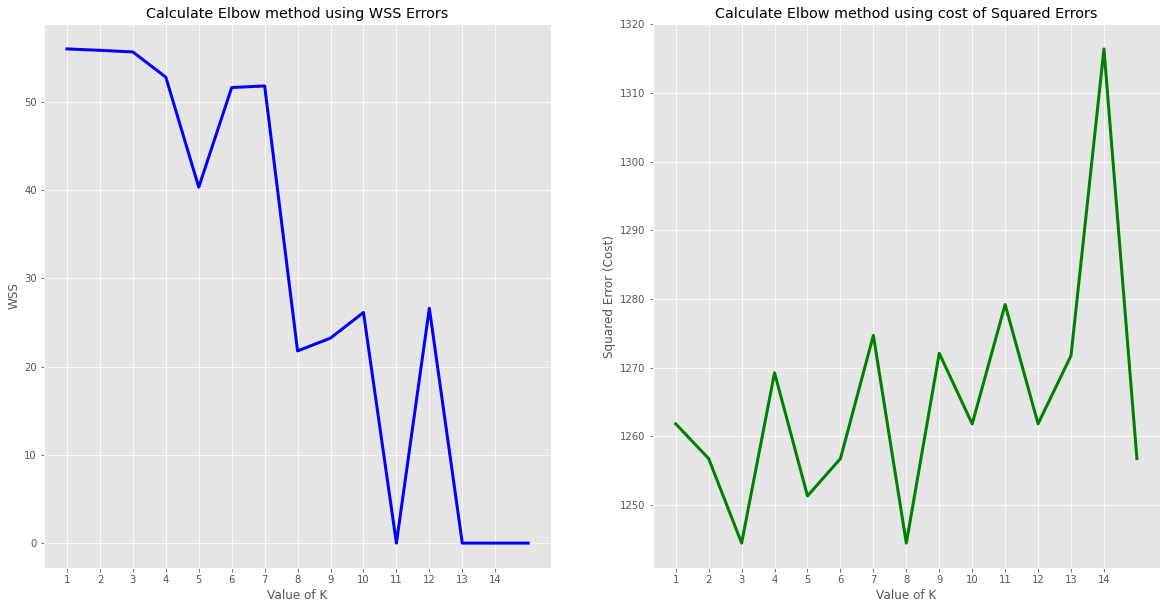

In [19]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

Ks = 15
sse = []

for n in range(1,Ks+1):
    x = StandardScaler().fit_transform(bali_group.drop(['City','Neighborhood'],axis=1).values)
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=12).fit(x)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(x)
    curr_sse = 0

    for i in range(len(x)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (x[i, 0] - curr_center[0]) ** 2 + (x[i, 1] - curr_center[1]) ** 2
    
    sse.append(curr_sse)

ax0.plot(range(1,Ks+1), sse, color='b', linewidth='3')
ax0.set_title('Calculate Elbow method using WSS Errors')
ax0.set_xticks(np.arange(1,Ks,1))
ax0.set_xlabel('Value of K')
ax0.set_ylabel('WSS')

# =========================================================================

cost = [] 
for i in range(1, Ks+1): 
    KM = KMeans(n_clusters=n, init='k-means++', n_init=12) 
    KM.fit(StandardScaler().fit_transform(bali_group.drop(['City','Neighborhood'],axis=1).values)) 
      
    cost.append(KM.inertia_)      
    
ax1.plot(range(1, Ks+1), cost, color ='g', linewidth ='3') 
ax1.set_title('Calculate Elbow method using cost of Squared Errors')
ax1.set_xticks(np.arange(1,Ks,1))
ax1.set_xlabel("Value of K") 
ax1.set_ylabel("Squared Error (Cost)") 

plt.show()

From above diagram, the best elbow point is at k=8, that will be used in the following k-means clustering analysis.

In [28]:
k = 8

#Normalization the data
x = StandardScaler().fit_transform(bali_group.drop(['Neighborhood','City'], axis=1).values)

#Generating k-means analysis
neigh_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=12)
neigh_kmeans.fit(x)

KMeans(n_init=12)

In [31]:
#Insert cluster label to the dataframe
venues_sorted.insert(0, 'Cluster Label', neigh_kmeans.labels_)

#Merging dataframe
bali_merged = bali_neigh.copy()
bali_merged.drop(['City'], axis=1, inplace=True)
bali_merged = bali_merged.join(venues_sorted.set_index('Neighborhood'), how='inner', on='Neighborhood').reset_index(drop=True)

bali_merged.drop(['Code','Postal'], axis=1, inplace=True)
bali_merged = bali_merged[[bali_merged.columns[4]] + bali_merged.columns[0:4].values.tolist() + bali_merged.columns[5:].values.tolist()]
bali_merged

,City,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,TABANAN,TABANAN,-8.517281,115.109111,3,Indonesian Restaurant,Chinese Restaurant,Café,Farmers Market,Food Truck
1,TABANAN,KEDIRI,-8.575016,115.118169,3,BBQ Joint,Café,Indonesian Restaurant,Convenience Store,Coffee Shop
2,TABANAN,MARGA,-8.450897,115.178237,2,Indonesian Restaurant,Park,BBQ Joint,Satay Restaurant,Restaurant
3,TABANAN,BATURITI,-8.346469,115.171748,2,Indonesian Restaurant,Restaurant,Asian Restaurant,Garden,Snack Place
4,BADUNG,KUTA SELATAN,-8.800775,115.162053,2,Resort,Café,Indonesian Restaurant,Seafood Restaurant,Beach
5,BADUNG,KUTA,-8.726381,115.171651,5,Coffee Shop,Clothing Store,Hotel,Spa,Multiplex
6,BADUNG,KUTA UTARA,-8.642908,115.152383,4,Café,Hotel,Asian Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant
7,BADUNG,MENGWI,-8.548036,115.154497,3,Indonesian Restaurant,Convenience Store,Food Court,Café,BBQ Joint
8,BADUNG,ABIANSEMAL,-8.528982,115.222016,0,Resort,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Asian Restaurant,Bistro
9,GIANYAR,SUKAWATI,-8.583323,115.275490,6,Art Gallery,Arts & Crafts Store,Indonesian Restaurant,Restaurant,Coffee Shop


Let's create Bali map displaying cluster labels for each respective neighborhood.

In [32]:
# create map
map_bali = folium.Map(location=[lat_bali, long_bali], zoom_start=9)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bali_merged['Latitude'], bali_merged['Longitude'], bali_merged['Neighborhood'], bali_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bali)
       
map_bali

### Examine Clusters

#### Cluster 1

In [33]:
bali_merged.loc[bali_merged['Cluster Label']==0, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,BADUNG,ABIANSEMAL,Resort,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Asian Restaurant,Bistro
12,GIANYAR,UBUD,Resort,Indonesian Restaurant,Vegetarian / Vegan Restaurant,Café,Asian Restaurant


#### Cluster 2

In [34]:
bali_merged.loc[bali_merged['Cluster Label']==1, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,KLUNGKUNG,BANJARANGKAN,Historic Site,Indonesian Restaurant,History Museum,Miscellaneous Shop,Cultural Center
16,KLUNGKUNG,KLUNGKUNG,BBQ Joint,History Museum,Miscellaneous Shop,Historic Site,Outdoors & Recreation
17,KLUNGKUNG,DAWAN,Beach,Seafood Restaurant,Indonesian Restaurant,Harbor / Marina,History Museum


#### Cluster 3

In [35]:
bali_merged.loc[bali_merged['Cluster Label']==2, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,TABANAN,MARGA,Indonesian Restaurant,Park,BBQ Joint,Satay Restaurant,Restaurant
3,TABANAN,BATURITI,Indonesian Restaurant,Restaurant,Asian Restaurant,Garden,Snack Place
4,BADUNG,KUTA SELATAN,Resort,Café,Indonesian Restaurant,Seafood Restaurant,Beach
11,GIANYAR,TAMPAKSIRING,Café,Indonesian Restaurant,Balinese Restaurant,Resort,Pedestrian Plaza
13,GIANYAR,TEGALLALANG,Café,Resort,Indonesian Restaurant,Balinese Restaurant,Coffee Shop
14,GIANYAR,PAYANGAN,Resort,Indonesian Restaurant,Coffee Shop,Paintball Field,Balinese Restaurant
18,BANGLI,SUSUT,Farm,Indonesian Restaurant,Garden,Coffee Shop,Chinese Restaurant
19,BANGLI,KINTAMANI,Indonesian Restaurant,Scenic Lookout,Mountain,Bed & Breakfast,Restaurant
20,KARANGASEM,MANGGIS,Resort,Hotel,Beach,Restaurant,Indonesian Restaurant
21,BULELENG,BANJAR,Hotel,Resort,Indonesian Restaurant,Balinese Restaurant,Coffee Shop


#### Cluster 4

In [36]:
bali_merged.loc[bali_merged['Cluster Label']==3, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,TABANAN,TABANAN,Indonesian Restaurant,Chinese Restaurant,Café,Farmers Market,Food Truck
1,TABANAN,KEDIRI,BBQ Joint,Café,Indonesian Restaurant,Convenience Store,Coffee Shop
7,BADUNG,MENGWI,Indonesian Restaurant,Convenience Store,Food Court,Café,BBQ Joint
23,BULELENG,BULELENG,Resort,Hotel,Beach,Indonesian Restaurant,Fast Food Restaurant
25,DENPASAR,DENPASAR TIMUR,Indonesian Restaurant,BBQ Joint,Asian Restaurant,Bakery,Chinese Restaurant
26,DENPASAR,DENPASAR BARAT,Indonesian Restaurant,Asian Restaurant,Coffee Shop,Food Truck,Hotel
27,DENPASAR,DENPASAR UTARA,Indonesian Restaurant,BBQ Joint,Seafood Restaurant,Asian Restaurant,Donut Shop


#### Cluster 5

In [37]:
bali_merged.loc[bali_merged['Cluster Label']==4, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,BADUNG,KUTA UTARA,Café,Hotel,Asian Restaurant,Yoga Studio,Vegetarian / Vegan Restaurant


#### Cluster 6

In [39]:
bali_merged.loc[bali_merged['Cluster Label']==5, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,BADUNG,KUTA,Coffee Shop,Clothing Store,Hotel,Spa,Multiplex


#### Cluster 7

In [41]:
bali_merged.loc[bali_merged['Cluster Label']==6, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,GIANYAR,SUKAWATI,Art Gallery,Arts & Crafts Store,Indonesian Restaurant,Restaurant,Coffee Shop
10,GIANYAR,BLAHBATUH,Theater,BBQ Joint,Bakery,Balinese Restaurant,Park


#### Cluster 8

In [42]:
bali_merged.loc[bali_merged['Cluster Label']==7, bali_merged.columns[[0]+[1]+list(range(5, bali_merged.shape[1]))]]

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,DENPASAR,DENPASAR SELATAN,Seafood Restaurant,Indonesian Restaurant,BBQ Joint,Korean Restaurant,Noodle House


### Result and Discussion

Based on the result of neighborhood clustering, we can analyze the main characteristics of each cluster by extracting what is the most common venue that are in each cluster compare with other clusters. Hence, below are the main characteristics of each cluster.

Cluster 1 : Resort, Vegan Restaurant

Cluster 2 : Historical Tourism (Site, Museum)

Cluster 3 : Natural Tourism (Farm, Mountain, Beach, Waterfall)

Cluster 4 : Asian Cuisine (Indonesian, Asian, Chinese Restaurant)

Cluster 5 : Cafe, Hotel

Cluster 6 : Coffee Shop, Clothing Store

Cluster 7 : Art (Gallery, Theather, Craft store)

Cluster 8 : Food Destination

Based on those main characteristics, the tourist can be more easily make a choice about which neighborhood to visit based on their own preferences. For example, if the tourist is more likely to visit the historical areas, we recommend them to visit neighborhood that are in cluster 2. This recommendation process could also be used for investor in making decision about where they want to open their business based on its business unit.